<a href="https://colab.research.google.com/github/andrea212023/ML-Kis/blob/main/HW_2_2_Imbalanced_classification_KIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, precision_score, recall_score
from scipy.stats import chi2_contingency

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek

In [ ]:
customer_segmentation_df = pd.read_csv("drive/MyDrive/Colab Notebooks/data/customer_segmentation_train.csv")

In [ ]:
customer_segmentation_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [ ]:
# Check for null values
print(customer_segmentation_df.isnull().sum())

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64


**Nota bene:**

We have null values, what implies that we must find a way to handle it before processing.

In [ ]:
# Data types of columns
print("\nColumn Data Types:")
print(customer_segmentation_df.dtypes)


Column Data Types:
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object


In [ ]:
# Describe the dataframe
print(customer_segmentation_df.describe())

                  ID          Age  Work_Experience  Family_Size
count    8068.000000  8068.000000      7239.000000  7733.000000
mean   463479.214551    43.466906         2.641663     2.850123
std      2595.381232    16.711696         3.406763     1.531413
min    458982.000000    18.000000         0.000000     1.000000
25%    461240.750000    30.000000         0.000000     2.000000
50%    463472.500000    40.000000         1.000000     3.000000
75%    465744.250000    53.000000         4.000000     4.000000
max    467974.000000    89.000000        14.000000     9.000000


In [ ]:
# Identify unique values
unique_counts = customer_segmentation_df.nunique()
print(unique_counts)

ID                 8068
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Var_1                 7
Segmentation          4
dtype: int64


In [ ]:
# Check for overdetermined or underdetermined system based on number of rows and features
num_rows = customer_segmentation_df.shape[0]
num_features = customer_segmentation_df.shape[1]
if num_rows > num_features:
    print("The system is overdetermined.")
elif num_rows < num_features:
    print("The system is underdetermined.")
else:
    print("The system is determined.")

The system is overdetermined.


In [ ]:
# Define categorical columns and calculate unique value counts
categorical_columns = customer_segmentation_df.select_dtypes(include=['object'])

# Use apply to calculate nunique() and unique() for efficiency
summary_unique_values = pd.DataFrame({
    "Column": categorical_columns.columns,
    "Number of Unique Values": categorical_columns.apply(pd.Series.nunique),
    "Unique Values": categorical_columns.apply(lambda col: col.unique())
})

# Display data types directly
print("Column Data Types:")
print(customer_segmentation_df.dtypes)

# Display the summary of unique values in categorical columns
print("\nUnique Values in Categorical Columns:")
print(summary_unique_values.sort_values(by="Number of Unique Values", ascending=False))  # Optional sorting


Column Data Types:
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

Unique Values in Categorical Columns:
                        Column  Number of Unique Values  \
Profession          Profession                        9   
Var_1                    Var_1                        7   
Segmentation      Segmentation                        4   
Spending_Score  Spending_Score                        3   
Gender                  Gender                        2   
Ever_Married      Ever_Married                        2   
Graduated            Graduated                        2   

                                                    Unique Values  
Profession      [Healthcare, Engineer, Lawyer, Entertainment, ...  
Var_1           [Cat_4

In [ ]:
# We need to handle missing values
# Use mode imputation for binary and categorical columns
customer_segmentation_df['Ever_Married'] = customer_segmentation_df['Ever_Married'].fillna(customer_segmentation_df['Ever_Married'].mode()[0])
customer_segmentation_df['Graduated'] = customer_segmentation_df['Graduated'].fillna(customer_segmentation_df['Graduated'].mode()[0])
customer_segmentation_df['Profession'] = customer_segmentation_df['Profession'].fillna(customer_segmentation_df['Profession'].mode()[0])
customer_segmentation_df['Var_1'] = customer_segmentation_df['Var_1'].fillna(customer_segmentation_df['Var_1'].mode()[0])

# Use median imputation for numeric columns with missing values
customer_segmentation_df['Family_Size'] = customer_segmentation_df['Family_Size'].fillna(customer_segmentation_df['Family_Size'].median())
customer_segmentation_df['Work_Experience'] = customer_segmentation_df['Work_Experience'].fillna(customer_segmentation_df['Work_Experience'].median())

# alternatively
# Convert Work_Experience to a categorical type with "unknown" for missing values
# customer_segmentation_df['Work_Experience'] = customer_segmentation_df['Work_Experience'].fillna("unknown")


In [ ]:
print(customer_segmentation_df.isnull().sum())

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64


Segmentation Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


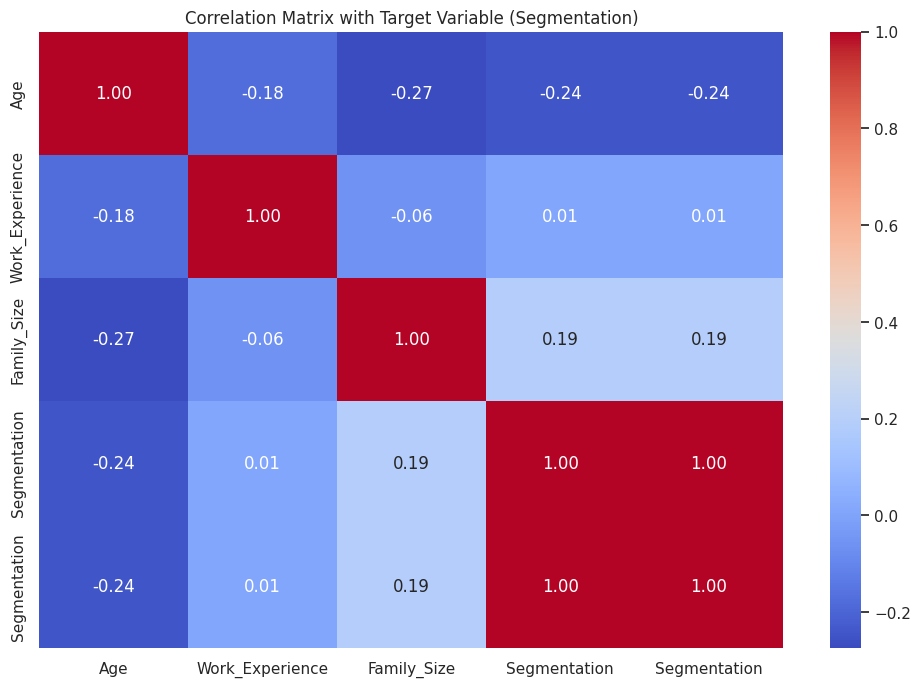


Chi-Square Test Results:
          Feature        p-value
3      Profession   0.000000e+00
4  Spending_Score   0.000000e+00
1    Ever_Married  1.882266e-296
2       Graduated  1.462416e-229
5           Var_1   2.474311e-41
0          Gender   9.618144e-03

Significant Categorical Features (p < 0.05):
          Feature        p-value
3      Profession   0.000000e+00
4  Spending_Score   0.000000e+00
1    Ever_Married  1.882266e-296
2       Graduated  1.462416e-229
5           Var_1   2.474311e-41
0          Gender   9.618144e-03


In [ ]:
# Encode the target variable
label_encoder = LabelEncoder()
customer_segmentation_df['Segmentation'] = label_encoder.fit_transform(customer_segmentation_df['Segmentation'])
segmentation_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Segmentation Mapping:", segmentation_mapping)

# Calculate correlation with numerical features
numerical_features = customer_segmentation_df.select_dtypes(include=[np.number]).drop(columns=['ID']).columns.tolist()
correlation_matrix = customer_segmentation_df[numerical_features + ['Segmentation']].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix with Target Variable (Segmentation)')
plt.show()

# Defining the chi-square test as a function with error handling ensures that the code can handle edge cases gracefully (e.g., columns with only one unique value).
# Calculate chi-square test for categorical features
categorical_features = customer_segmentation_df.select_dtypes(include=['object']).columns.tolist()

def chi_square_test(feature, target):
    try:
        contingency_table = pd.crosstab(customer_segmentation_df[feature], customer_segmentation_df[target])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        return p
    except ValueError as e:
        print(f"Skipping {feature}: {e}")
        return None

# Store chi-square test results in a DataFrame
chi_square_results = pd.DataFrame({
    'Feature': categorical_features,
    'p-value': [chi_square_test(feature, 'Segmentation') for feature in categorical_features]
}).dropna().sort_values(by='p-value')

# Display chi-square test results
print("\nChi-Square Test Results:")
print(chi_square_results)

# Optional: Highlight statistically significant features
significance_threshold = 0.05
significant_features = chi_square_results[chi_square_results['p-value'] < significance_threshold]
print("\nSignificant Categorical Features (p < 0.05):")
print(significant_features)

**Observations:**

1. All Categorical Features are Statistically Significant:
The p-values for all categorical features (Profession, Spending_Score, Ever_Married, Graduated, Var_1, and Gender) are well below the significance threshold of 0.05. This indicates that each of these features has a statistically significant association with the target variable (Segmentation).
2. Very Low P-Values for Key Features:
Profession and Spending_Score have p-values of 0.000000e+00, suggesting extremely strong associations with the target variable. This could mean that Segmentation is particularly sensitive to changes in Profession and Spending_Score.
3. The other features, such as Ever_Married, Graduated, and Var_1, also have extremely low p-values, indicating a strong association with Segmentation.
Gender Has the Highest P-Value:
4. Although still statistically significant, Gender has the highest p-value (9.618144e-03) among all categorical features. This suggests that Gender may have a weaker association with Segmentation compared to other features.

**Conclusions:**
1. Significant Predictors: All tested categorical features have a significant association with Segmentation, which implies that they can be meaningful predictors in a model aiming to predict customer segmentation.
2. Importance of Profession and Spending_Score: Given their extremely low p-values, Profession and Spending_Score are likely to be the most influential categorical features for predicting Segmentation. They should be prioritized in any feature selection or model-building efforts.
3. Potential for Feature Engineering: Since all categorical variables contribute significantly, further feature engineering could be beneficial. For instance, creating interaction terms or grouping categories within Profession and Spending_Score might enhance model performance.
4. Even though the numerical features show a weak correlation with the target variable, they should be retained in the model. This is because their influence might become significant when combined with other features, potentially enhancing the model's accuracy.

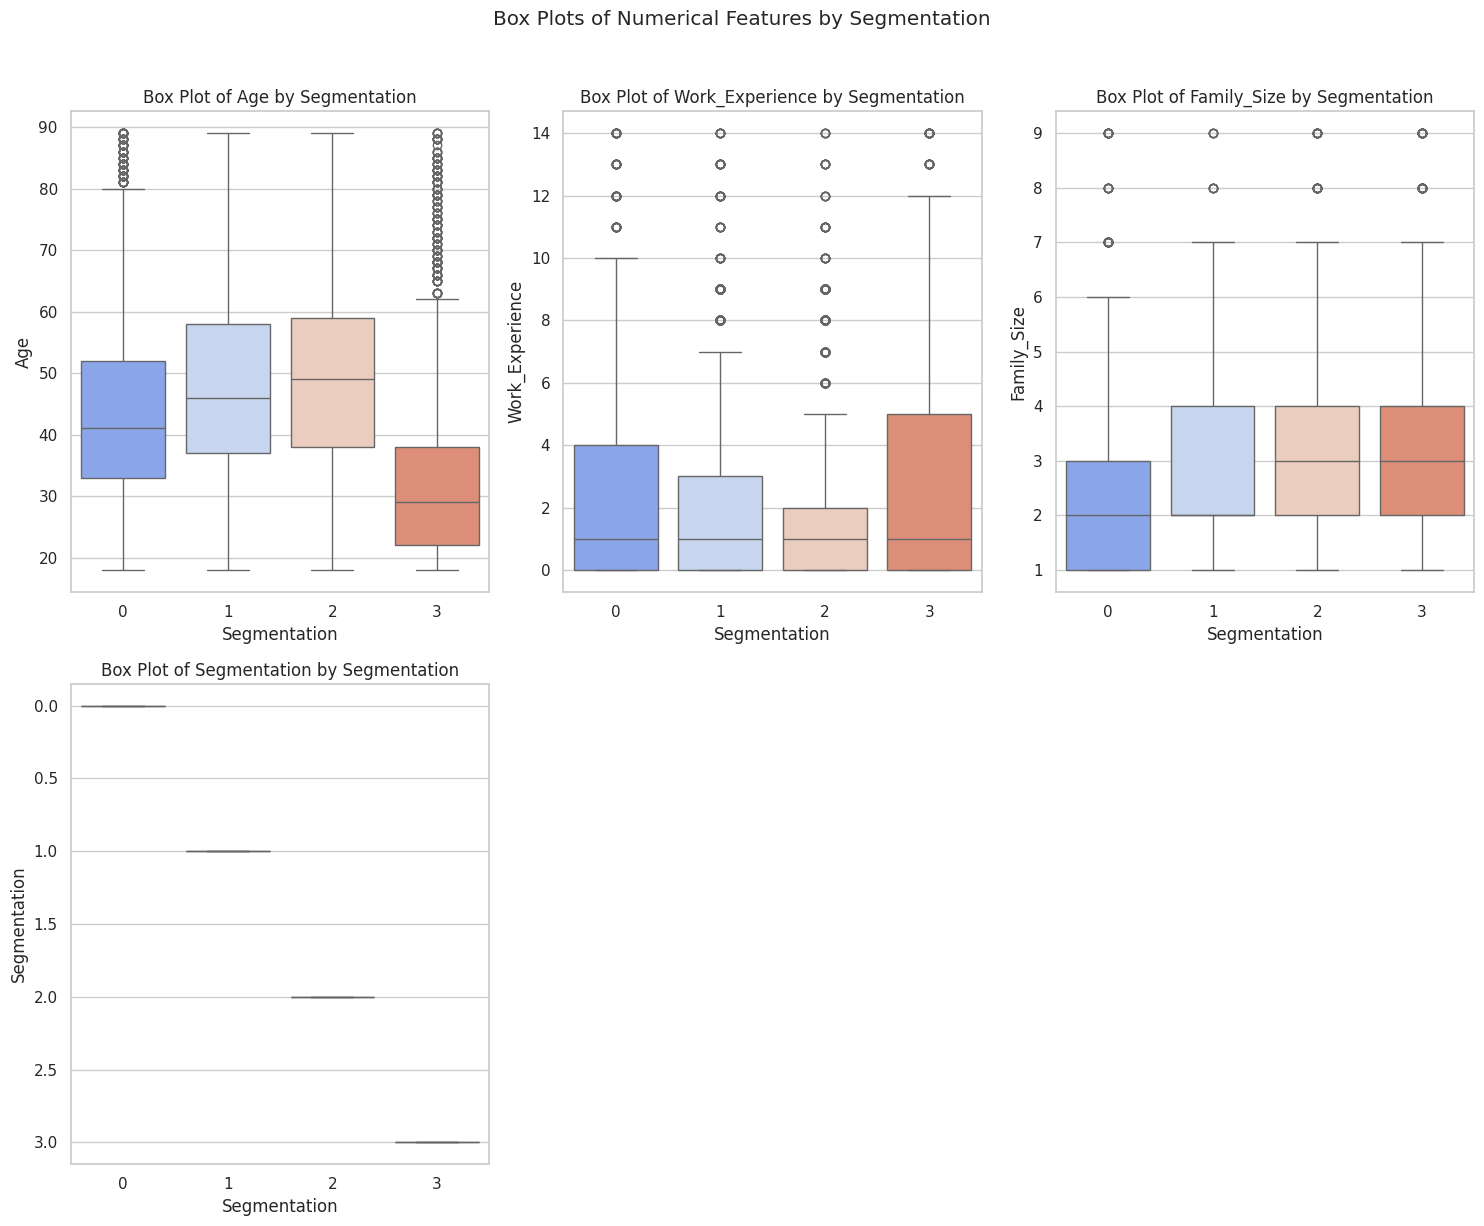

In [ ]:
# Let's draw box plots for numerical features to see if we have outliers
import math

# Set plot style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", len(customer_segmentation_df['Segmentation'].unique()))

# Number of numerical features and subplot layout
num_numerical_features = len(numerical_features)
num_cols = 3
num_rows = math.ceil(num_numerical_features / num_cols)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 6 * num_rows))
fig.suptitle('Box Plots of Numerical Features by Segmentation', y=1.02)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Plot each numerical feature as a box plot with the custom palette
for i, feature in enumerate(numerical_features):
    sns.boxplot(x='Segmentation', y=feature, data=customer_segmentation_df, hue='Segmentation', ax=axs[i], palette=palette, dodge=False, legend=False)
    axs[i].set_title(f'Box Plot of {feature} by Segmentation')
    axs[i].set_xlabel('Segmentation')
    axs[i].set_ylabel(feature)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


**Nota bene:**

We will have to deal with outliers before analysis.

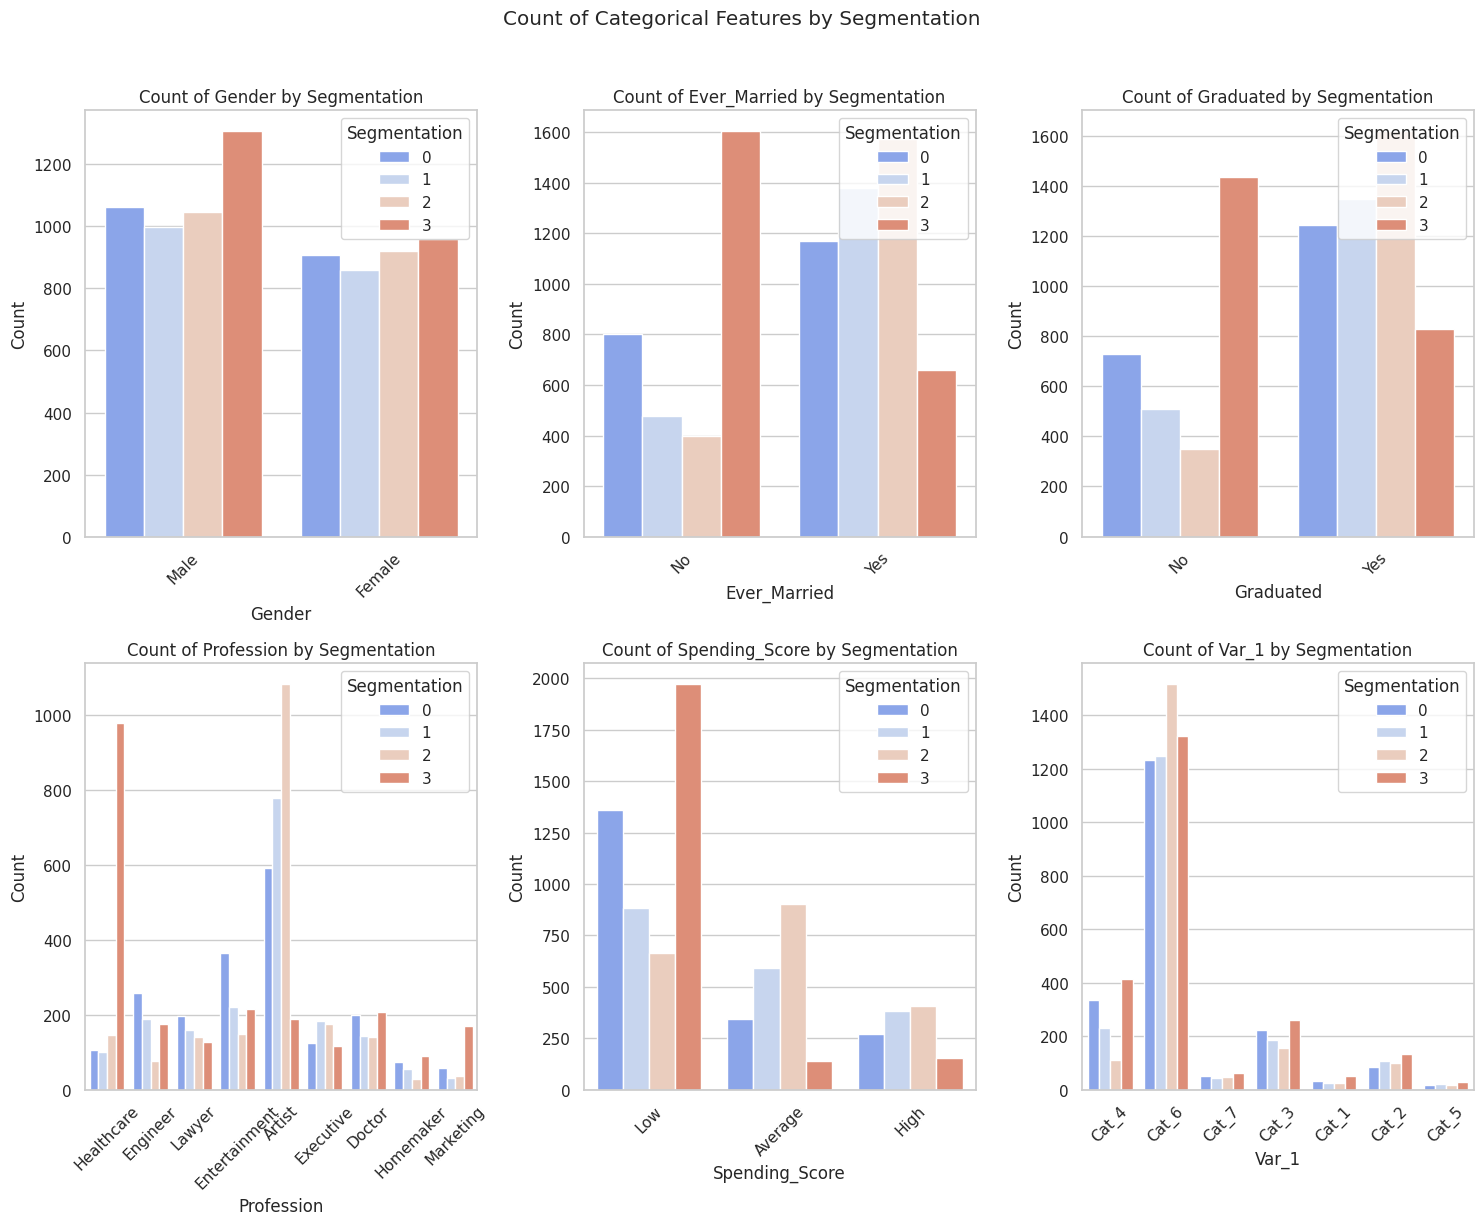

In [ ]:
# Let's explore categorical features and their relation to Segmentation
import math

# Define number of rows and columns based on the number of categorical features
num_features = len(categorical_features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 6 * num_rows))
fig.suptitle('Count of Categorical Features by Segmentation', y=1.02)

# Flatten axs to easily index it
axs = axs.flatten()

# Plot each categorical feature in a subplot
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='Segmentation', data=customer_segmentation_df, palette=palette, ax=axs[i])
    axs[i].set_title(f'Count of {feature} by Segmentation')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability
    axs[i].legend(title='Segmentation', loc='upper right')

# Hide any empty subplots (in case num_features is not a perfect multiple of num_cols)
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [ ]:
# Encode numeric and categorical features
numeric_features = ['Age', 'Work_Experience', 'Family_Size']
categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

# Create pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Create pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define features (x) and target variable (y)
X = customer_segmentation_df.drop('Segmentation', axis=1)
y = customer_segmentation_df['Segmentation']

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train logistic regression
log_reg = LogisticRegression(solver='liblinear')

# Create pipeline for One-vs-Rest model
ovr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', OneVsRestClassifier(log_reg))])

# Create pipeline for One-vs-One model
ovo_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', OneVsOneClassifier(log_reg))])

# Train the pipelines on the training dataset
ovr_pipeline.fit(X_train, y_train)
ovo_pipeline.fit(X_train, y_train)

# Predict on the test dataset
ovr_predictions = ovr_pipeline.predict(X_test)
ovo_predictions = ovo_pipeline.predict(X_test)


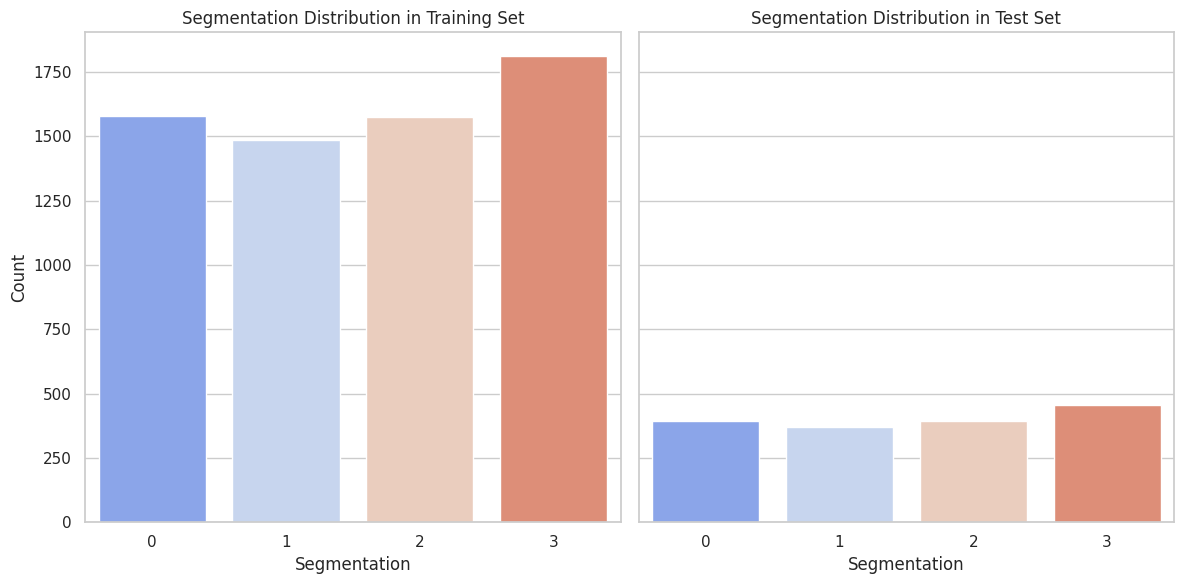

In [ ]:
# Visualise distribution in training and test datasets # unfortunately palette coolwarm is deprecated
# Convert y_train and y_test to DataFrames with a column named "Class"
y_train_df = pd.DataFrame({"Segmentation": y_train})
y_test_df = pd.DataFrame({"Segmentation": y_test})

# Define the color palette
unique_classes = sorted(y_train.unique())
palette = sns.color_palette("coolwarm", len(unique_classes))

# Visualize distribution in training and test datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Training set distribution
sns.countplot(ax=axes[0], x="Segmentation", hue="Segmentation", data=y_train_df, order=unique_classes, palette=palette, legend=False) # unfortunately palette coolwarm is deprecated
axes[0].set_title('Segmentation Distribution in Training Set')
axes[0].set_xlabel('Segmentation')
axes[0].set_ylabel('Count')

# Test set distribution
sns.countplot(ax=axes[1], x="Segmentation", hue="Segmentation", data=y_test_df, order=unique_classes, palette=palette, legend=False)
axes[1].set_title('Segmentation Distribution in Test Set')
axes[1].set_xlabel('Segmentation')

plt.tight_layout()
plt.show()

In [ ]:
# Define metric functions and averaging types
metrics = {'Precision': precision_score, 'Recall': recall_score}
averages = ['macro', 'micro']

# Calculate metrics for OvR and OvO in a loop
results = {'Metric': [], 'OvR': [], 'OvO': []}
for metric_name, metric_func in metrics.items():
    for avg in averages:
        # Calculate OvR and OvO metrics
        ovr_result = metric_func(y_test, ovr_predictions, average=avg)
        ovo_result = metric_func(y_test, ovo_predictions, average=avg)

        # Append results
        results['Metric'].append(f'{avg.capitalize()} {metric_name}')
        results['OvR'].append(ovr_result)
        results['OvO'].append(ovo_result)

# Convert results dictionary to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Print classification reports for both models
print("Classification Report for OvR:")
print(classification_report(y_test, ovr_predictions))
print("Classification Report for OvO:")
print(classification_report(y_test, ovo_predictions))

            Metric       OvR       OvO
0  Macro Precision  0.490262  0.491390
1  Micro Precision  0.513631  0.511772
2     Macro Recall  0.499645  0.499763
3     Micro Recall  0.513631  0.511772
Classification Report for OvR:
              precision    recall  f1-score   support

           0       0.42      0.45      0.43       394
           1       0.41      0.18      0.25       372
           2       0.49      0.61      0.54       394
           3       0.65      0.76      0.70       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614

Classification Report for OvO:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40       394
           1       0.41      0.27      0.33       372
           2       0.51      0.58      0.55       394
           3       0.64      0.74      0.69       454

    accuracy                        

**Observations:**

1. Similar Performance Between OvR and OvO:

The metrics for the One-vs-Rest (OvR) and One-vs-One (OvO) strategies are quite similar across both precision and recall, with minor differences in each category.
Both strategies achieve overall low precision and recall scores, indicating room for improvement in model performance.
2. Macro and Micro Metrics:

Both macro and micro precision and recall metrics are around 0.49 to 0.51, which suggests that the model’s overall performance across classes is balanced but relatively low.
Macro metrics (which calculate the metric independently for each class and then take the average) and micro metrics (which aggregate the contributions of all classes) are close in value. This may indicate that the dataset is relatively balanced across classes.

3. Class-Level Performance:

The performance varies significantly across classes:

Class 3 has the highest precision and recall in both OvR and OvO strategies, with precision around 0.64 and recall around 0.74 in OvO.

Class 1 has notably lower recall, especially in OvR (0.18), indicating that this class is underrepresented or challenging to classify correctly.

The F1-scores also vary by class, with higher values for class 3 and lower values for class 1.

4. Low Overall Accuracy:

The overall accuracy for both OvR and OvO is 0.51, which is close to random guessing for a four-class problem.

Macro and weighted averages of precision, recall, and F1-score are all around 0.49-0.51, reinforcing that the model struggles with distinguishing between classes.

**Conclusions:**

1. Model Performance is Suboptimal:

Both OvR and OvO strategies have low performance metrics across the board, suggesting that the current model may not be effective at distinguishing between classes.

2. Class Imbalance or Difficult Classes:

The low recall for certain classes, especially class 1, indicates that the model may be struggling with specific classes. This could be due to class imbalance, insufficient feature differentiation, or inadequate model complexity.

3. OvO and OvR Perform Similarly:

Given that both approaches yield similar results, the choice of OvR vs. OvO may not significantly impact this model’s performance.

**Recommendations for Improvement:**

1. Feature Engineering:

Create New Features: Look for additional informative features that may help differentiate between classes. For example, engineered features or domain-specific transformations could improve model performance.

Feature Selection: Use techniques like Recursive Feature Elimination (RFE) or feature importance ranking to identify the most relevant features and eliminate noise.

2. Address Class Imbalance:

If class imbalance exists, consider techniques like oversampling (e.g., SMOTE) for minority classes or undersampling for majority classes to balance the dataset.

Alternatively, you could use class weights in the model to penalize misclassification of minority classes more heavily.

3. Hyperparameter Tuning:

Perform a grid search or random search on hyperparameters to find optimal settings for the model, which might improve classification results.

Experiment with different regularization parameters, kernel settings (if using SVM), and other model-specific parameters to enhance performance.

4. Use a Different Model:

Ensemble Methods: Try ensemble methods like Random Forest, Gradient Boosting, or XGBoost to potentially improve classification accuracy and handle non-linear relationships better.

Neural Networks: If you have a large amount of data, a neural network or deep learning approach may be effective in capturing complex patterns.

5. Evaluate Additional Metrics:

ROC-AUC Score: For multi-class problems, calculate the ROC-AUC score for each class to understand how well the model distinguishes each class from the rest.

Confusion Matrix: Visualize a confusion matrix to identify specific misclassifications, which can guide targeted improvements.

6. Cross-Validation:

Implement k-fold cross-validation to ensure that the model’s performance is consistent across different splits of the dataset. This can provide a better understanding of model robustness and reduce overfitting.

In [ ]:
# Check the lengths to verify consistency
print("Length of y_test:", len(y_test))
print("Length of ovr_predictions:", len(ovr_predictions))
print("Length of ovo_predictions:", len(ovo_predictions))


Length of y_test: 1614
Length of ovr_predictions: 1614
Length of ovo_predictions: 1614


In [ ]:
# Let's delete outliers
# Before outlier removal
print("Original shape:", customer_segmentation_df.shape)

# Outlier removal code
Q1 = customer_segmentation_df[numeric_features].quantile(0.25)
Q3 = customer_segmentation_df[numeric_features].quantile(0.75)
IQR = Q3 - Q1

# Create a mask to filter out outliers for all numeric features
mask = (customer_segmentation_df[numeric_features] >= (Q1 - 1.5 * IQR)) & (customer_segmentation_df[numeric_features] <= (Q3 + 1.5 * IQR))
customer_segmentation_df_filtered = customer_segmentation_df[mask.all(axis=1)]

# After outlier removal
print("Filtered shape:", customer_segmentation_df_filtered.shape)


Original shape: (8068, 11)
Filtered shape: (7720, 11)


In [ ]:
# Define numeric and categorical features
numeric_features = ['Age', 'Work_Experience', 'Family_Size']
categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

# Create pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define features (X) and target variable (y) from the filtered DataFrame
X_filtered = customer_segmentation_df_filtered.drop('Segmentation', axis=1)
y_filtered = customer_segmentation_df_filtered['Segmentation']

# Split into training and test datasets using the filtered data
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)

# Initialize logistic regression model
log_reg = LogisticRegression(solver='liblinear')

# Create pipeline for One-vs-Rest model with preprocessor
ovr_pipeline_filtered = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', OneVsRestClassifier(log_reg))
])

# Create pipeline for One-vs-One model with preprocessor
ovo_pipeline_filtered = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', OneVsOneClassifier(log_reg))
])

# Train the pipelines on the filtered training dataset
ovr_pipeline_filtered.fit(X_train_filtered, y_train_filtered)
ovo_pipeline_filtered.fit(X_train_filtered, y_train_filtered)

# Print completion message
print("Training for OvR and OvO models on filtered data is complete.")

Training for OvR and OvO models on filtered data is complete.


In [ ]:
# Predict on the filtered test dataset
ovr_predictions_filtered = ovr_pipeline_filtered.predict(X_test_filtered)
ovo_predictions_filtered = ovo_pipeline_filtered.predict(X_test_filtered)

# Print completion message
print("Predictions on the filtered test dataset are complete.")

Predictions on the filtered test dataset are complete.


In [ ]:
# Define metrics and averaging types
metrics = {'Precision': precision_score, 'Recall': recall_score}
averages = ['macro', 'micro']
models = {'OvR': ovr_predictions_filtered, 'OvO': ovo_predictions_filtered}

# Calculate metrics for each combination and store results in a dictionary
results = {'Metric': [], 'OvR': [], 'OvO': []}
for metric_name, metric_func in metrics.items():
    for avg in averages:
        # Generate the label for this metric
        metric_label = f'{avg.capitalize()} {metric_name}'
        results['Metric'].append(metric_label)

        # Calculate and store the metric for each model (OvR and OvO)
        for model_name, predictions in models.items():
            metric_value = metric_func(y_test_filtered, predictions, average=avg)
            results[model_name].append(metric_value)

# Convert results dictionary to a DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)

# Print classification reports for both models on filtered data
print("Classification Report for OvR on Filtered Data:")
print(classification_report(y_test_filtered, ovr_predictions_filtered))
print("Classification Report for OvO on Filtered Data:")
print(classification_report(y_test_filtered, ovo_predictions_filtered))

            Metric       OvR       OvO
0  Macro Precision  0.489063  0.499217
1  Micro Precision  0.514249  0.514249
2     Macro Recall  0.502497  0.504308
3     Micro Recall  0.514249  0.514249
Classification Report for OvR on Filtered Data:
              precision    recall  f1-score   support

           0       0.41      0.50      0.45       373
           1       0.38      0.13      0.20       360
           2       0.52      0.66      0.58       381
           3       0.65      0.71      0.68       430

    accuracy                           0.51      1544
   macro avg       0.49      0.50      0.48      1544
weighted avg       0.50      0.51      0.49      1544

Classification Report for OvO on Filtered Data:
              precision    recall  f1-score   support

           0       0.41      0.46      0.43       373
           1       0.42      0.26      0.32       360
           2       0.53      0.60      0.56       381
           3       0.65      0.70      0.67       430

  

**Conclusion:**

Deletion of outliers almost did not enhance the model performance of both OvR an OvO.

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [ ]:
# Create pipeline for regression with SMOTE
pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', log_reg)])

# Train and predict with SMOTE
pipeline_smote.fit(X_train, y_train)
y_pred_smote = pipeline_smote.predict(X_test)

# Evaluate model with SMOTE
print("SMOTE Logistic Regression")
print(classification_report(y_test, y_pred_smote))
print("Accuracy:", accuracy_score(y_test, y_pred_smote))

SMOTE Logistic Regression
              precision    recall  f1-score   support

           0       0.43      0.50      0.46       394
           1       0.44      0.26      0.33       372
           2       0.51      0.61      0.56       394
           3       0.68      0.71      0.70       454

    accuracy                           0.53      1614
   macro avg       0.52      0.52      0.51      1614
weighted avg       0.52      0.53      0.52      1614

Accuracy: 0.530359355638166


In [164]:
# Create index for categorical features
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# Create pipeline for regression with SMOTENC
pipeline_smotenc = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotenc', SMOTENC(categorical_features=cat_feature_indices, random_state=42)),
    ('classifier', log_reg)])

# Train and predict with SMOTENC
pipeline_smotenc.fit(X_train, y_train)
y_pred_smotenc = pipeline_smotenc.predict(X_test)

# Evaluate model with SMOTENC
print("SMOTENC Logistic Regression")
print(classification_report(y_test, y_pred_smotenc))
print("Accuracy:", accuracy_score(y_test, y_pred_smotenc))

SMOTENC Logistic Regression
              precision    recall  f1-score   support

           0       0.43      0.49      0.46       394
           1       0.43      0.26      0.32       372
           2       0.51      0.61      0.55       394
           3       0.68      0.70      0.69       454

    accuracy                           0.52      1614
   macro avg       0.51      0.51      0.51      1614
weighted avg       0.52      0.52      0.51      1614

Accuracy: 0.5247831474597274


In [165]:
# Create pipeline for regression with SMOTE-Tomek
pipeline_smotetomek = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotetomek', SMOTETomek(smote=SMOTENC(categorical_features=cat_feature_indices, random_state=42), random_state=42)),
    ('classifier', log_reg)])

# Train and predict with SMOTE-Tomek
pipeline_smotetomek.fit(X_train, y_train)
y_pred_smotetomek = pipeline_smotetomek.predict(X_test)

# Evaluate model with SMOTE-Tomek
print("SMOTE-Tomek Logistic Regression")
print(classification_report(y_test, y_pred_smotetomek))
print("Accuracy:", accuracy_score(y_test, y_pred_smotetomek))

SMOTE-Tomek Logistic Regression
              precision    recall  f1-score   support

           0       0.42      0.49      0.45       394
           1       0.45      0.24      0.32       372
           2       0.52      0.62      0.56       394
           3       0.68      0.71      0.69       454

    accuracy                           0.53      1614
   macro avg       0.52      0.52      0.51      1614
weighted avg       0.52      0.53      0.52      1614

Accuracy: 0.5278810408921933


**Conclusion:**

All three models have comparable metrics and accuracy approximately 52.5-53, being able to predict 3rd and 4th class of Segmentation the best.

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [166]:
# Original model (without resampling)
ovr_pipeline_original = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', OneVsRestClassifier(log_reg))
])
ovr_pipeline_original.fit(X_train, y_train)
y_pred_original = ovr_pipeline_original.predict(X_test)

# Model with SMOTE
ovr_pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', OneVsRestClassifier(log_reg))
])
ovr_pipeline_smote.fit(X_train, y_train)
y_pred_smote = ovr_pipeline_smote.predict(X_test)

# Model SMOTE-Tomek
ovr_pipeline_smotetomek = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotetomek', SMOTETomek(random_state=42)),
    ('classifier', OneVsRestClassifier(log_reg))
])
ovr_pipeline_smotetomek.fit(X_train, y_train)
y_pred_smotetomek = ovr_pipeline_smotetomek.predict(X_test)

# Print results
print("Original Logistic Regression")
print(classification_report(y_test, y_pred_original))
print("\nSMOTE Logistic Regression")
print(classification_report(y_test, y_pred_smote))
print("\nSMOTE-Tomek Logistic Regression")
print(classification_report(y_test, y_pred_smotetomek))

Original Logistic Regression
              precision    recall  f1-score   support

           0       0.43      0.49      0.46       394
           1       0.45      0.18      0.26       372
           2       0.51      0.64      0.57       394
           3       0.67      0.75      0.70       454

    accuracy                           0.53      1614
   macro avg       0.51      0.52      0.50      1614
weighted avg       0.52      0.53      0.51      1614


SMOTE Logistic Regression
              precision    recall  f1-score   support

           0       0.43      0.50      0.46       394
           1       0.44      0.26      0.33       372
           2       0.51      0.61      0.56       394
           3       0.68      0.71      0.70       454

    accuracy                           0.53      1614
   macro avg       0.52      0.52      0.51      1614
weighted avg       0.52      0.53      0.52      1614


SMOTE-Tomek Logistic Regression
              precision    recall  f1-sco

**Conclusion:**

In my results, I do not see a significant difference in all three models, their performance is comparable (f1-score specifically).

SMOTE often doesn’t improve logistic regression performance because:

1. Linear Decision Boundary: Logistic regression assumes a linear boundary, so synthetic data points created by SMOTE don’t add meaningful information if the data is already nearly linearly separable.

Mathematical Reasoning: Logistic regression finds the weights (coefficients) that maximize the likelihood of the observed outcomes, given a linear combination of features. When adding synthetic data points that lie on or near the existing decision boundary, these points won’t provide additional information about the optimal weights, as the decision boundary is already well-defined.

2. Redundant Information: SMOTE interpolates within the minority class, creating points that are linearly dependent on existing ones. For a linear model, this doesn’t change the decision boundary significantly.

Mathematical Reasoning: In linear algebra terms, interpolated data points created by SMOTE lie within the convex hull of the minority class points. For a linear classifier, this doesn’t alter the model’s weights significantly because these synthetic points do not introduce new directions or variations outside of the existing data structure.

3. Class Imbalance Robustness: Logistic regression optimizes for class probabilities rather than relying heavily on sample counts, so class balancing doesn’t have as much impact.

Mathematical Reasoning: Logistic regression optimizes the weights to minimize a loss function (like cross-entropy), which is not overly sensitive to exact sample counts for each class. Instead, it adjusts weights based on class probabilities, which means that duplicating or interpolating points in the minority class doesn’t significantly alter the loss landscape.

4. Feature Complexity: If the issue is a lack of complex features, SMOTE won’t help. Adding new features or using a non-linear model may provide better results.

Mathematical Reasoning: Logistic regression is a parametric model, meaning its capacity to model relationships is limited by the feature set and the linear assumption. If my features don’t adequately separate the classes, adding synthetic data within the existing feature space won’t increase the model’s capacity to capture patterns.

In summary, SMOTE is more beneficial for complex models that can capture non-linear patterns, while logistic regression may perform well enough with class weight adjustments instead.